# Scraped Review Statistics

In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt

## Remove Duplicates

In [15]:
def remove_duplicates(file_path):
    if os.stat(file_path).st_size == 0:
        print(f"{file_path} is empty")
        return
    
    df = pd.read_csv(file_path)

    if df.empty:
        print(f"{file_path} is empty")
        return
    
    cleaned_df = df.drop_duplicates(subset=['user_name','text'], ignore_index=True)
    cleaned_df.to_csv(file_path, index=False, mode='w')

In [16]:
def process_all_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            remove_duplicates(file_path)
            print(f"Processed {filename}")

In [17]:
review_path = "../../Data/Reviews_Scraped/Raw"
# process_all_files(review_path)

In [26]:
metadata_path = "../../Data/Goodreads_Comics_Data/Data_Files/Masterdata_ongoing.xlsx"
metadata = pd.read_excel(metadata_path, sheet_name="BOOK_SHEET")
goodreads_id = metadata['goodreads_id'].tolist()

In [27]:
collected_reviews = [f for f in os.listdir(review_path) if f.endswith('.csv')]
collected_ids = [f.split('_reviews.csv')[0] for f in collected_reviews]

missing_ids = list(set(goodreads_id) - set(collected_ids))
missing_ids

['57553105-cypress-hill-tres-equis',
 '63234758-growing-up-farley-a-chris-farley-story',
 '59113162-one-bourbon-one-scotch-one-beer',
 '49930973-clayton']

In [9]:
def get_scraped_review_num(filepath):
    df = pd.read_csv(filepath)
    return len(df)

files = ["17346698-march", "29436571-march", "52211831-they-called-us-enemy", "22487952-march"]

for file in files:
    print(get_scraped_review_num(f"../../Data/Reviews_Scraped/Raw/{file}_reviews.csv"))

3420
2819
4950
2339


**Unscraped**

63234758-growing-up-farley-a-chris-farley-story: no reviews

57553105-cypress-hill-tres-equis: 0 reviews

49930973-clayton: 0 reviews

59113162-one-bourbon-one-scotch-one-beer: 0 reviews

**Unfinished scraping**

17346698-march: 5965 reviews, 3420 scraped

22487952-march: 2712 reviews, 2339 scraped

29436571-march: 3106 reviews, 2819 scraped

52211831-they-called-us-enemy: 6449 reviews, 4950 scraped

## Review number statistics

In [23]:
# read in the metadata

metadata = pd.read_excel(metadata_path, sheet_name="BOOK_SHEET")

# initiate book_review_df

book_review_df = pd.DataFrame(columns=['goodreads_id', 'scraped_review_num'])

# for each book in the metadata, check how many reviews are scraped

collected_files = [f for f in os.listdir(review_path) if f.endswith('.csv')]

# Create an empty list to collect all data rows
data = []

# for each book in the metadata, check how many reviews are scraped
for _, row in metadata.iterrows():  # Use iterrows() to iterate over DataFrame rows
    book_id = row["book_id"]
    goodreads_id = row['goodreads_id']

    if f"{goodreads_id}_reviews.csv" in collected_files:
        review_num = get_scraped_review_num(f"../../Data/Reviews_Scraped/Raw/{goodreads_id}_reviews.csv")
    else:
        review_num = 0

    # Add each row to the list
    data.append({'book_id': book_id, 'scraped_review_num': review_num})

# Convert the list to DataFrame at once
book_review_df = pd.DataFrame(data)


In [24]:
# Save the DataFrame to an Excel file
with pd.ExcelWriter(metadata_path, mode='a', engine='openpyxl', if_sheet_exists='new') as writer:
    book_review_df.to_excel(writer, sheet_name="BOOK_REVIEW_SHEET", index=False)

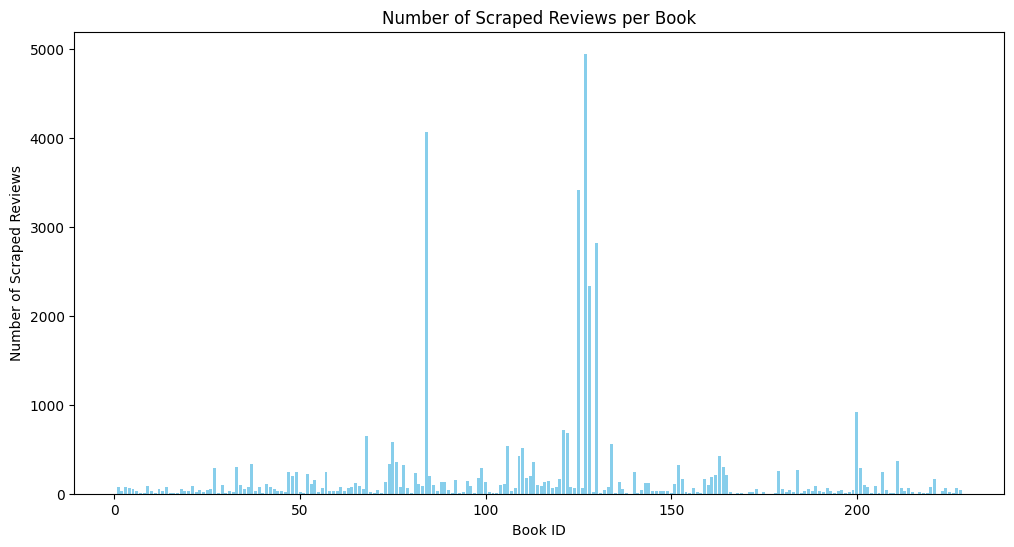

In [29]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(book_review_df['book_id'], book_review_df['scraped_review_num'], color='skyblue')
plt.xlabel('Book ID')
plt.ylabel('Number of Scraped Reviews')
plt.title('Number of Scraped Reviews per Book')
plt.show()

In [32]:
# Generate descriptive statistics for book_review_df
book_review_df["scraped_review_num"].describe().round(2)

count     228.00
mean      176.24
std       538.21
min         0.00
25%        19.00
50%        51.50
75%       127.50
max      4950.00
Name: scraped_review_num, dtype: float64

In [33]:
large_review_df = book_review_df[book_review_df["scraped_review_num"] > 1000]
large_review_df

,book_id,scraped_review_num
83,84,4066
124,125,3420
126,127,4950
127,128,2339
129,130,2819


In [47]:
large_review_data = []

for _, row in large_review_df.iterrows():
    book_id = row["book_id"]
    goodreads_id = metadata[metadata["book_id"] == book_id]["goodreads_id"].values[0]
    title = metadata[metadata["book_id"] == book_id]["title"].values[0]
    scraped_review_num = row["scraped_review_num"]
    large_review_data.append({'book_id': book_id, 'goodreads_id': goodreads_id, 'title': title, 'scraped_review_num': scraped_review_num})

# Convert the list to a DataFrame
large_review_df = pd.DataFrame(large_review_data)
large_review_df

,book_id,goodreads_id,title,scraped_review_num
0,84,13332696-my-friend-dahmer,My Friend Dahmer: A Gaphic Novel,4066
1,125,17346698-march,March: Book One,3420
2,127,52211831-they-called-us-enemy,They Called Us Enemy: Expanded Edition,4950
3,128,22487952-march,March: Book Two,2339
4,130,29436571-march,March: Book Three,2819


In [35]:
normal_review_df = book_review_df[~book_review_df["book_id"].isin(large_review_df["book_id"])]
normal_review_df

,book_id,scraped_review_num
0,1,79
1,2,28
2,3,72
3,4,62
4,5,48
...,...,...
223,224,69
224,225,18
225,226,7
226,227,70


In [38]:
normal_review_df["scraped_review_num"].describe().round(2)

count    223.00
mean     101.29
std      140.77
min        0.00
25%       19.00
50%       48.00
75%      116.50
max      925.00
Name: scraped_review_num, dtype: float64

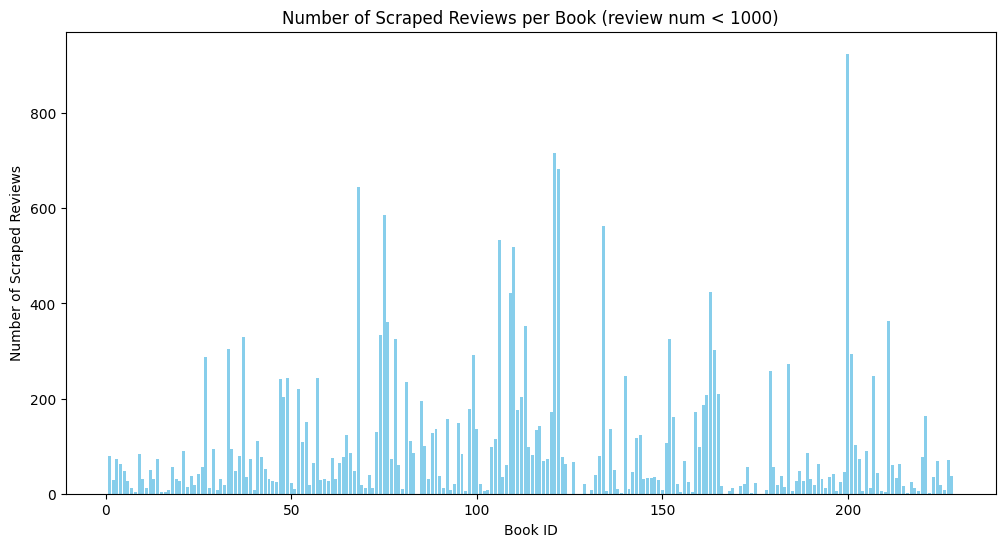

In [37]:
plt.figure(figsize=(12, 6))
plt.bar(normal_review_df['book_id'], normal_review_df['scraped_review_num'], color='skyblue')
plt.xlabel('Book ID')
plt.ylabel('Number of Scraped Reviews')
plt.title('Number of Scraped Reviews per Book (review num < 1000)')
plt.show()